# Dog vs Cat - 基於VGG16的transfer learning

利用Kaggle的Dogs vs Cats做VGG16的transfer learning 的學習

[資料集](https://www.kaggle.com/c/dogs-vs-cats)


#### Tranfer learning 有兩種方法可以達到
1. 載入pre-training model，把後面幾層的分類層替換掉符合需求的神經元結構，並且重新訓練他們  
    優點：可做fine-tune，可以利用data-generator做資料擴充來做更多的訓練
    缺點：速度慢，因為必須在每次的訓練都經過特徵擷取的運算
  
   
2. 利用pre-training model的特徵擷取層，讓檔案藉由特徵擷取後的檔案輸入我們設計的神經元訓練
    優點：快速，由於把特徵擷取這最肥大的部分以計算完，在後面的訓練只需要提取檔案就好
    缺點：除了無法fine-tune與擴充資料以外，還需要把資料都放在記憶體內，這在龐大數據集無法使用

## Phase1. 移花接木--在pre-training mode 後面接上自定義神經元

### Step1. 資料預處理

首先需要把當前的資料另外建立出一個資料夾結構如下
目的是為了使用keras內建的檔案處理data generator的load_from_dictionary來利用資料夾做分類

```
root_floder/  
   ├────/TRAIN  
   |      ├──/DOG  
   |      └──/CAT  
   └────/TEST  
         ├──/DOG  
         └──/CAT  
```

In [5]:
import os

ROOT_DIR = os.getcwd()
DATA_PATH = os.path.join(ROOT_DIR, "dogs-vs-cats")
SOURCE_DATA_DIR = os.path.join(DATA_PATH, "train")

print('length of train data %d' %(len(os.listdir(TRAIN_DIR))))

length of train data 2


In [6]:
BASE_DIR = os.path.join(DATA_PATH, "VGG_Practice")
if not os.path.exists(BASE_DIR):
    os.mkdir(BASE_DIR)
    
TRAIN_DIR = os.path.join(BASE_DIR, "TRAIN")
if not os.path.exists(TRAIN_DIR):
    os.mkdir(TRAIN_DIR)
    
TEST_DIR = os.path.join(BASE_DIR, "TEST")
if not os.path.exists(TEST_DIR):
    os.mkdir(TEST_DIR)
    
DOG_TRAIN = os.path.join(TRAIN_DIR, "DOG")
if not os.path.exists(DOG_TRAIN):
    os.mkdir(DOG_TRAIN)

CAT_TRAIN = os.path.join(TRAIN_DIR, "CAT")
if not os.path.exists(CAT_TRAIN):
    os.mkdir(CAT_TRAIN)
    
DOG_TEST = os.path.join(TEST_DIR, "DOG")
if not os.path.exists(DOG_TEST):
    os.mkdir(DOG_TEST)
    
CAT_TEST = os.path.join(TEST_DIR, "CAT")
if not os.path.exists(CAT_TEST):
    os.mkdir(CAT_TEST)


In [7]:
import shutil

for frame in ['cat.{}.jpg'.format(i) for i in range(0,2000)]:
    source = os.path.join(SOURCE_DATA_DIR,frame)
    target = os.path.join(CAT_TRAIN,frame)
    if not os.path.exists(target):
        shutil.copyfile(source,target)

for frame in ['dog.{}.jpg'.format(i) for i in range(0,2000)]:
    source = os.path.join(SOURCE_DATA_DIR,frame)
    target = os.path.join(DOG_TRAIN,frame)
    if not os.path.exists(target):
        shutil.copyfile(source,target)
        
for frame in ['cat.{}.jpg'.format(i) for i in range(10000,11000)]:
    source = os.path.join(SOURCE_DATA_DIR,frame)
    target = os.path.join(CAT_TEST,frame)
    if not os.path.exists(target):
        shutil.copyfile(source,target)
        
for frame in ['dog.{}.jpg'.format(i) for i in range(10000,11000)]:
    source = os.path.join(SOURCE_DATA_DIR,frame)
    target = os.path.join(DOG_TEST,frame)
    if not os.path.exists(target):
        shutil.copyfile(source,target)

#### ImageDataGenerator詳細操作
[ImageDataGenerator document](https://keras.io/zh/preprocessing/image/)

In [9]:
from keras.preprocessing.image import ImageDataGenerator

# normalizing
train_gen = ImageDataGenerator(rescale=1./255,validation_split=0.2)
test_gen = ImageDataGenerator(rescale=1./255)

batch_size = 20

train_datagen = train_gen.flow_from_directory(
            TRAIN_DIR,
            target_size=(224,224),
            batch_size=batch_size,
            class_mode='binary',
            subset='training'
            )

validation_datagen = train_gen.flow_from_directory(
            TRAIN_DIR,
            target_size=(224,224),
            batch_size=batch_size,
            class_mode='binary',
            subset='validation'
            )

test_datagen = test_gen.flow_from_directory(
            TEST_DIR,
            target_size=(224,224),
            batch_size=batch_size,
            class_mode='binary',
            )

for train_batch, label_batch in train_datagen:
    print('train_batch_shape: ', train_batch.shape)
    print('label_batch_shape: ', label_batch.shape)
    break;

Found 3200 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
train_batch_shape:  (20, 224, 224, 3)
label_batch_shape:  (20,)


### Step 2. model setting

這裡我利用VGG16  
宣告模型的時候在include_top部分設定為false  
這樣就會只會把特徵萃取層取出  
可以在model summary看出來

In [10]:
from keras.applications import VGG16

vgg_model = VGG16(weights='imagenet',include_top=False,input_shape=(224,224,3))
vgg_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
bloc

後面接上自訂定義的神經元  
並且把前面的特徵萃取層的訓練關閉  
可以看到最後Trainable params: 由14M降到250K

In [17]:
from keras.layers import Dense, Flatten, Dropout
from keras.models import Sequential

model = Sequential()

model.add(vgg_model)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(10,activation = 'relu'))
model.add(Dense(10,activation = 'relu'))
model.add(Dense(1,activation = 'sigmoid'))

vgg_model.trainable = False
    
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                250890    
_________________________________________________________________
dense_8 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 11        
Total params: 14,965,699
Trainable params: 251,011
Non-trainable params: 14,714,688
__________________________________________________________

### Step3. 訓練與結果

由於我們的train_date與validation data是利用preprocess unit的data generator產生的  
這裡利用fit_generator來訓練我們的模型  
詳細文檔參閱  
[fit_generator document](https://keras-cn.readthedocs.io/en/latest/models/model/)



In [24]:
model.compile(loss='binary_crossentropy',optimizer = 'adam', metrics = ['acc'])

train_history = model.fit_generator(train_datagen,
                                    steps_per_epoch=train_datagen.samples/batch_size,
                                    epochs=20,
                                    validation_data=validation_datagen,
                                    validation_steps=validation_datagen.samples/batch_size,
                                    verbose=1)

Epoch 1/20
160/160 [==============================] - 23s 145ms/step - loss: 0.0369 - acc: 0.9862 - val_loss: 0.2435 - val_acc: 0.9250
Epoch 2/20
160/160 [==============================] - 23s 145ms/step - loss: 0.0311 - acc: 0.9881 - val_loss: 0.2429 - val_acc: 0.9250
Epoch 3/20
160/160 [==============================] - 23s 144ms/step - loss: 0.0381 - acc: 0.9859 - val_loss: 0.2205 - val_acc: 0.9362
Epoch 4/20
160/160 [==============================] - 23s 145ms/step - loss: 0.0393 - acc: 0.9825 - val_loss: 0.2056 - val_acc: 0.9325
Epoch 5/20
160/160 [==============================] - 23s 146ms/step - loss: 0.0328 - acc: 0.9881 - val_loss: 0.2791 - val_acc: 0.9225
Epoch 6/20
160/160 [==============================] - 23s 145ms/step - loss: 0.0418 - acc: 0.9856 - val_loss: 0.2878 - val_acc: 0.9175
Epoch 7/20
160/160 [==============================] - 23s 146ms/step - loss: 0.0484 - acc: 0.9809 - val_loss: 0.3170 - val_acc: 0.9150
Epoch 8/20
160/160 [==============================] - 2

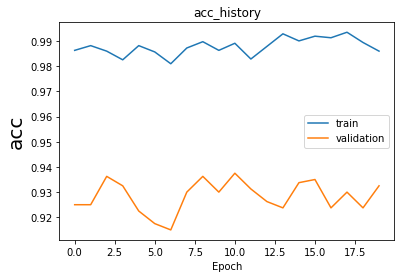

In [50]:
import matplotlib.pyplot as plt

def plot_train_result(train_history,train,val):
    plt.figure()
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[val])
    plt.legend(['train','validation'])
    plt.title(train+'_history')
    plt.xlabel('Epoch')
    plt.ylabel(train,fontsize=20)
    plt.show()
    
plot_train_result(train_history,'acc','val_acc')

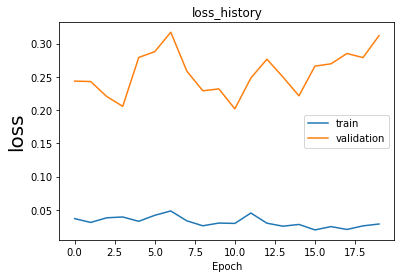

In [51]:
plot_train_result(train_history,'loss','val_loss')

In [52]:
scores = model.evaluate_generator(test_datagen,steps= 10)
print('test data accuracy: %.2f' %(scores[1]*100))

test data accuracy: 93.00


從測試資料集，我們可以看到這模型獲得了93%的預測成功率

In [53]:
# this is use to save mode
#model.save('dog-vs-cat-vgg16.h5')

## Phase 2. 利用pre-training mode 提取特徵在放入我們的模型

### Step1. 提取特徵萃取資料

利用Datagen來提取特徵資料

In [46]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(1./255)



def ExtractData(DIR):  # trager folder
    sub_dir=os.path.join(DIR,'DOG')
    total_data = len(os.listdir(sub_dir))*2
    
    # first, need to create container
    feature_data = np.zeros(shape=(total_data,7,7,512)) # meet VGG16 last output shape
    label_data = np.zeros(shape=(total_data))
    
    feture_gen = datagen.flow_from_directory(
            DIR,
            target_size=(224,224),
            batch_size=100,
            class_mode='binary')
    i=0
    for feature , label in feture_gen:
        feature = vgg_model.predict(feature)
        feature_data[i*100:(i+1)*100]=feature
        label_data[i*100:(i+1)*100]=label
        i+=1
        if i >= total_data/100:
            break
    
    return feature_data , label_data

必須另外設置一組Validation用的圖片集

In [43]:
VAL_DIR = os.path.join(BASE_DIR, "Validation")
if not os.path.exists(VAL_DIR):
    os.mkdir(VAL_DIR)
    
DOG_VAL = os.path.join(VAL_DIR, "DOG")
if not os.path.exists(DOG_VAL):
    os.mkdir(DOG_VAL)

CAT_VAL = os.path.join(VAL_DIR, "CAT")
if not os.path.exists(CAT_VAL):
    os.mkdir(CAT_VAL)
    
for frame in ['cat.{}.jpg'.format(i) for i in range(2001,3001)]:
    source = os.path.join(SOURCE_DATA_DIR,frame)
    target = os.path.join(CAT_VAL,frame)
    if not os.path.exists(target):
        shutil.copyfile(source,target)

for frame in ['dog.{}.jpg'.format(i) for i in range(2001,3001)]:
    source = os.path.join(SOURCE_DATA_DIR,frame)
    target = os.path.join(DOG_VAL,frame)
    if not os.path.exists(target):
        shutil.copyfile(source,target)

利用剛剛定義的特徵提取函數來提取資料

In [47]:
Train_data, Train_label = ExtractData(TRAIN_DIR)
Test_data, Test_label = ExtractData(TEST_DIR)
Val_data, Val_label = ExtractData(VAL_DIR)

print('Train_data shape: ', Train_data.shape,' and label shape: ',  Train_label.shape)
print('Test_data shape: ', Test_data.shape,' and label shape: ',  Test_label.shape)
print('Val_data shape: ', Val_data.shape,' and label shape: ',  Val_label.shape)

Found 4000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Train_data shape:  (4000, 7, 7, 512)  and label shape:  (4000,)
Test_data shape:  (2000, 7, 7, 512)  and label shape:  (2000,)
Val_data shape:  (2000, 7, 7, 512)  and label shape:  (2000,)


輸出的資料為特層萃取的結果，我們需要把他們壓扁
來給全連結層作為輸入使用

In [49]:
Train_data = Train_data.reshape(4000,-1)
Test_data = Test_data.reshape(2000,-1)
Val_data  = Val_data.reshape(2000,-1)

Train_data shape:  (4000, 25088)


### Step2. 搭建模型與訓練

In [57]:


model2 = Sequential()



model2.add(Dense(10,input_dim=7*7*512,activation='relu'))
model2.add(Dense(10,activation = 'relu'))
model2.add(Dense(1,activation = 'sigmoid'))

model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 10)                250890    
_________________________________________________________________
dense_17 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 11        
Total params: 251,011
Trainable params: 251,011
Non-trainable params: 0
_________________________________________________________________


可以看到訓練參數一樣是250K

### Step3. 模型訓練與評估
用跟剛剛一樣的方法訓練

In [58]:
model2.compile(loss='binary_crossentropy',optimizer = 'adam', metrics = ['acc'])

train_history2 = model2.fit(Train_data,Train_label,batch_size=100,epochs=20,validation_data=(Val_data,Val_label),verbose=1)

Train on 4000 samples, validate on 2000 samples
Epoch 1/20
4000/4000 [==============================] - 2s 457us/step - loss: 0.7725 - acc: 0.8078 - val_loss: 0.1633 - val_acc: 0.9360
Epoch 2/20
4000/4000 [==============================] - 1s 311us/step - loss: 0.1114 - acc: 0.9613 - val_loss: 0.1082 - val_acc: 0.9615
Epoch 3/20
4000/4000 [==============================] - 1s 312us/step - loss: 0.0335 - acc: 0.9865 - val_loss: 0.1186 - val_acc: 0.9635
Epoch 4/20
4000/4000 [==============================] - 1s 312us/step - loss: 0.0172 - acc: 0.9925 - val_loss: 0.1408 - val_acc: 0.9620
Epoch 5/20
4000/4000 [==============================] - 1s 315us/step - loss: 0.0078 - acc: 0.9963 - val_loss: 0.1362 - val_acc: 0.9655
Epoch 6/20
4000/4000 [==============================] - 1s 311us/step - loss: 0.0045 - acc: 0.9973 - val_loss: 0.1241 - val_acc: 0.9715
Epoch 7/20
4000/4000 [==============================] - 1s 311us/step - loss: 0.0026 - acc: 0.9983 - val_loss: 0.1420 - val_acc: 0.9680


由於特徵已經先算完了，所以運算速度跟Phase1比起來相差巨大，每個epoch只需要一秒

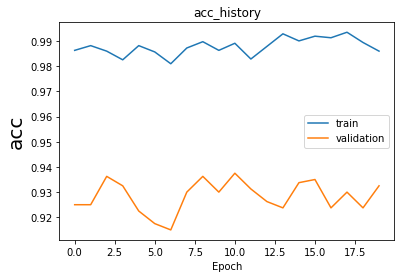

In [60]:
plot_train_result(train_history,'acc','val_acc')

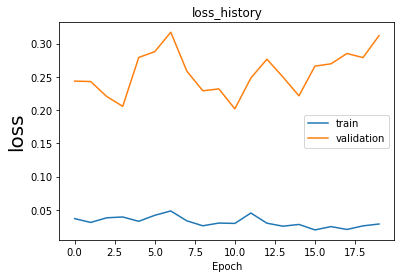

In [61]:
plot_train_result(train_history,'loss','val_loss')

In [59]:
score2 = model2.evaluate(Test_data,Test_label)

print('Accuary of test data: %.1f'%(score2[1]*100))

2000/2000 [==============================] - 0s 242us/step
Accuary of test data: 96.5


### Summary

由於我是利用VGG16,原本imagenet的分類器內已經有貓跟狗的訓練集了
所以在這裡利用VGG16來做貓狗大戰得到的分數都滿高的